# Thin Gaussian Shells with Uniform Prior

This is a toy model shows how Nested Sampling easily handles likelihoods with multimodal behaviour.

$L(x) = P(y | x) = \log(e^{f(x,c_1,r_1,w_1)} + e^{f(x,c_2,r_2,w_2)}) $

where $f(x,c,r,w) = -\frac{1}{2 w^2}(|x - c| - r)^2 - \log(\sqrt(2 \pi w^2))$

and

$P(x) = \mathcal{U}[x \mid -6, 6 \pi]$.

In [1]:
from jax.config import config

config.update("jax_enable_x64", True)

import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import ExactNestedSampler
from jaxns import Model
from jaxns import PriorModelGen, Prior
from jaxns import TerminationCondition
from jaxns import bruteforce_evidence

tfpd = tfp.distributions

INFO[2023-06-15 15:24:15,057]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-06-15 15:24:15,058]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-15 15:24:15,058]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-15 15:24:15,059]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-06-15 15:24:15,059]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2023-06-15 15:24:15,060]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:

def log_likelihood(theta):
    def log_circ(theta, c, r, w):
        return -0.5 * (jnp.linalg.norm(theta - c) - r) ** 2 / w ** 2 - jnp.log(jnp.sqrt(2 * jnp.pi * w ** 2))

    w1 = w2 = jnp.array(0.1)
    r1 = r2 = jnp.array(2.)
    c1 = jnp.array([0., -3.])
    c2 = jnp.array([0., 3.])
    return jnp.logaddexp(log_circ(theta, c1, r1, w1), log_circ(theta, c2, r2, w2))


def prior_model() -> PriorModelGen:
    x = yield Prior(tfpd.Uniform(low=-6. * jnp.ones(2), high=6. * jnp.ones(2)), name='theta')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

log_Z_true = bruteforce_evidence(model=model, S=250)
print(f"True log(Z)={log_Z_true}")

True log(Z)=-1.7456418720467646


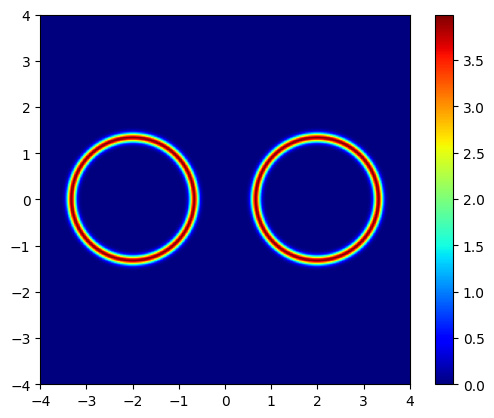

In [3]:

u_vec = jnp.linspace(0., 1., 250)
args = jnp.stack([x.flatten() for x in jnp.meshgrid(*[u_vec] * model.U_ndims, indexing='ij')], axis=-1)

# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(model.forward)(args).reshape((u_vec.size, u_vec.size))

plt.imshow(jnp.exp(lik), origin='lower', extent=(-4, 4, -4, 4), cmap='jet')
plt.colorbar()
plt.show()

In [4]:


# Create the nested sampler class. In this case without any tuning.
exact_ns = ExactNestedSampler(model=model, num_live_points=200, num_parallel_samplers=1, max_samples=1e4)

termination_reason, state = exact_ns(random.PRNGKey(42),
                                     term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = exact_ns.to_results(state, termination_reason)


In [5]:
# We can use the summary utility to display results
exact_ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 49977
# samples: 1800
# slices: 4800.0
# slices / acceptance: 6.0
# likelihood evals / sample: 27.8
# likelihood evals / slice: 8.9
--------
logZ=-1.85 +- 0.12
H=4.7
ESS=343
--------
theta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
theta[0]: 0.1 +- 1.4 | -1.9 / 0.2 / 1.9 | 1.0 | 1.0
theta[1]: 0.3 +- 3.3 | -4.7 / 1.3 / 4.5 | -4.7 | -4.7
--------


WARNING[2023-06-15 15:24:28,185]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


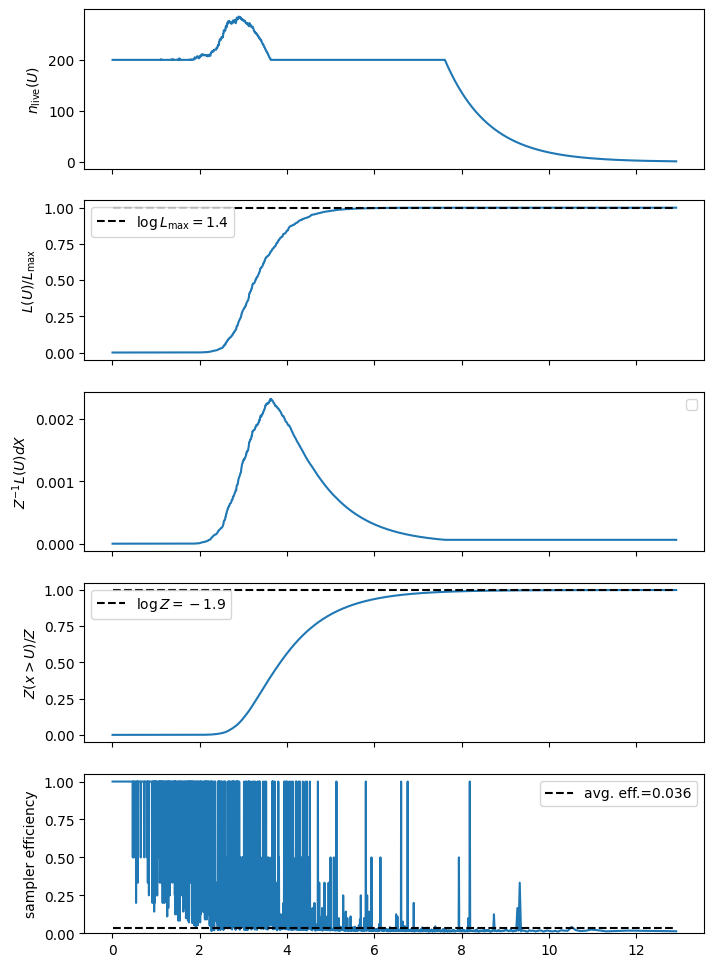

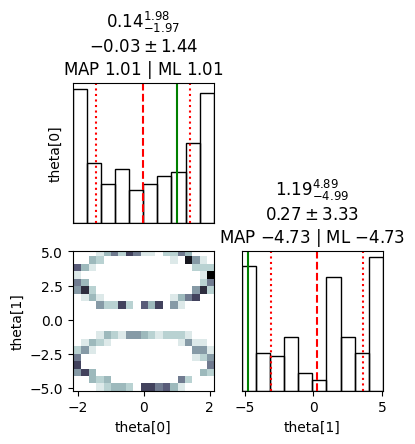

In [6]:
# We plot useful diagnostics and a distribution cornerplot
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)